In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from zipfile import ZipFile

data_path = 'lung_image_sets.zip'

with ZipFile(data_path,'r') as zip:
    zip.extractall()
print('The data set has been extracted.')


The data set has been extracted.


In [3]:
path = 'lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

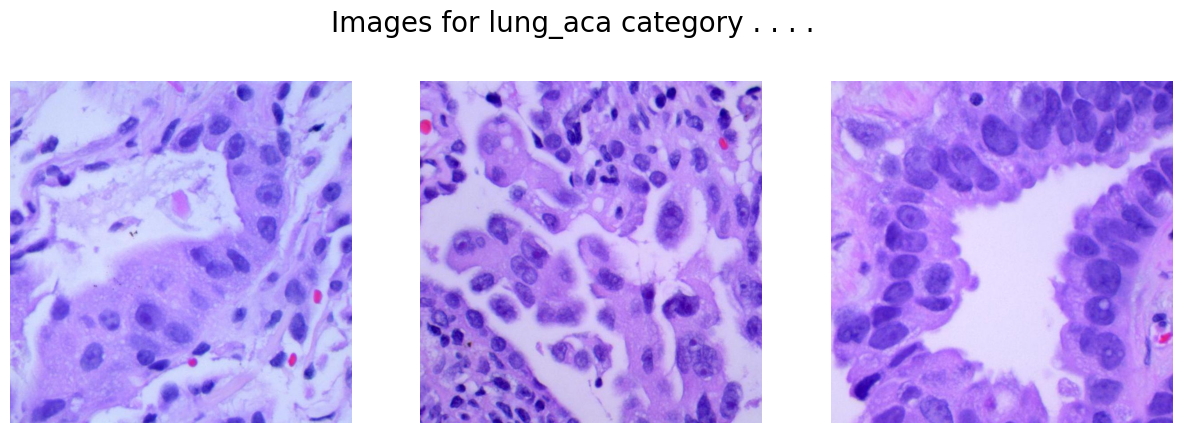

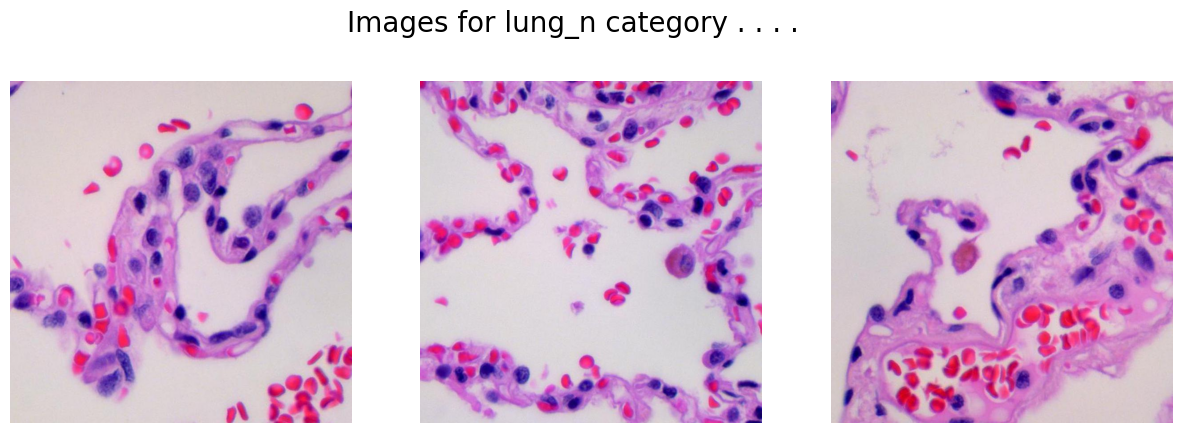

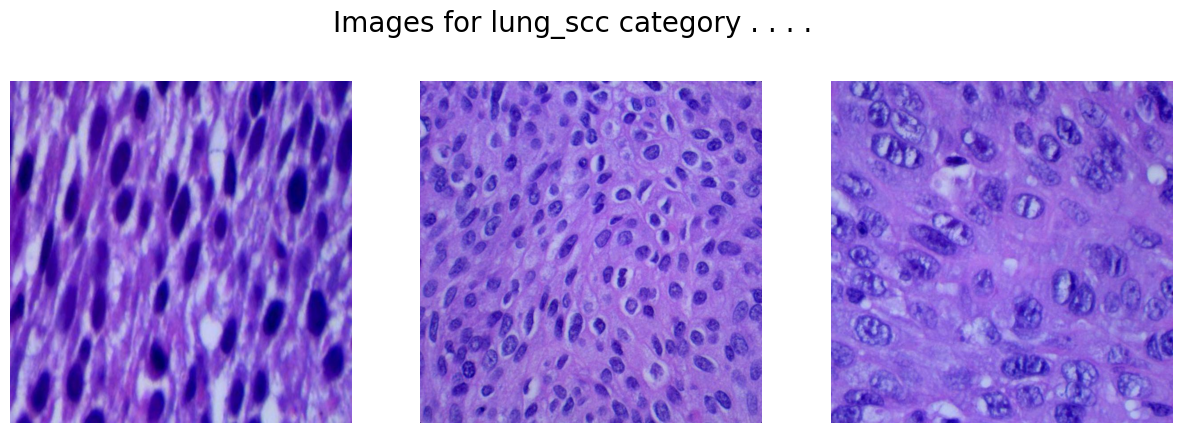

In [4]:
path = 'lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 5
BATCH_SIZE = 64

In [6]:
# it takes lots of time to train the model

X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

for image in images:
	img = cv2.imread(image)
	
	X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
	Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Example data generation (replace this with your actual data loading or generation process)

num_samples = 15000
num_features = 3

# Generate random data for X (features) and one_hot_encoded_Y (labels)
X = np.random.rand(num_samples, num_features)  # Replace this with your actual data
one_hot_encoded_Y = np.random.randint(0, 2, size=(num_samples, 1))  # Example one-hot encoded labels

# Check the shapes of the arrays
print("Shape of X:", X.shape)
print("Shape of one_hot_encoded_Y:", one_hot_encoded_Y.shape)

# Ensure they have the same number of samples
assert X.shape[0] == one_hot_encoded_Y.shape[0], "Mismatched number of samples in X and one_hot_encoded_Y"

# Define the split ratio (e.g., 20% for validation)
SPLIT = 0.2

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)

# Print the shapes of the resulting splits
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)


Shape of X: (15000, 3)
Shape of one_hot_encoded_Y: (15000, 1)
Shape of X_train: (12000, 3)
Shape of X_val: (3000, 3)
Shape of Y_train: (12000, 1)
Shape of Y_val: (3000, 1)


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 3) (3000, 3)


In [9]:
# ## original one

model = keras.models.Sequential([
 	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
 				activation='relu',
 				input_shape=(IMG_SIZE,
 							IMG_SIZE,
 							3),
 				padding='same'),
 	layers.MaxPooling2D(2, 2),

 	layers.Conv2D(filters=64,
 				kernel_size=(3, 3),
 				activation='relu',
 				padding='same'),
 	layers.MaxPooling2D(2, 2),

 	layers.Conv2D(filters=128,
 				kernel_size=(3, 3),
 				activation='relu',
 				padding='same'),
	layers.MaxPooling2D(2, 2),

 	layers.Flatten(),
 	layers.Dense(256, activation='relu'),
 	layers.BatchNormalization(),
 	layers.Dense(128, activation='relu'),
 	layers.Dropout(0.3),
 	layers.BatchNormalization(),
 	layers.Dense(3, activation='softmax')
 ])

In [10]:
# !pip install pydot
# !pip install graphviz
# !pip install pydot-ng

In [11]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [12]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [14]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

print(X_train.shape)
print(X_val.shape)


Shape of X_train: (12000, 3)
Shape of X_val: (3000, 3)
(12000, 3)
(3000, 3)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to [0, 1]
    validation_split=0.2   # Use 20% of the data for validation
)

# Create training data generator
train_generator = datagen.flow_from_directory(
    'lung_image_sets', # Replace with the path to your training data
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'  # Use 'rgb' to ensure 3 channels
)

# Create validation data generator
validation_generator = datagen.flow_from_directory(
    'lung_image_sets', # Replace with the path to your training data
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'  # Use 'rgb' to ensure 3 channels
)


Found 11988 images belonging to 3 classes.
Found 2997 images belonging to 3 classes.


In [16]:
weights_dir = 'weights'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)


In [17]:
weights_path = os.path.join(weights_dir, 'weights.weights.h5')
model.save_weights(weights_path)


In [18]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.8072 - loss: 0.4467 - val_accuracy: 0.3333 - val_loss: 7.1812
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9061 - loss: 0.2284 - val_accuracy: 0.6590 - val_loss: 2.5563
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9268 - loss: 0.1892 - val_accuracy: 0.3557 - val_loss: 4.8119
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9460 - loss: 0.1399 - val_accuracy: 0.4074 - val_loss: 3.2959
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9513 - loss: 0.1260 - val_accuracy: 0.6680 - val_loss: 3.9784


In [19]:
# Original One 

# history = model.fit(X_train, Y_train,
# 					validation_data = (X_val, Y_val),
# 					batch_size = BATCH_SIZE,
# 					epochs = EPOCHS,
# 					verbose = 1,
# 					callbacks = [es, lr, myCallback()])


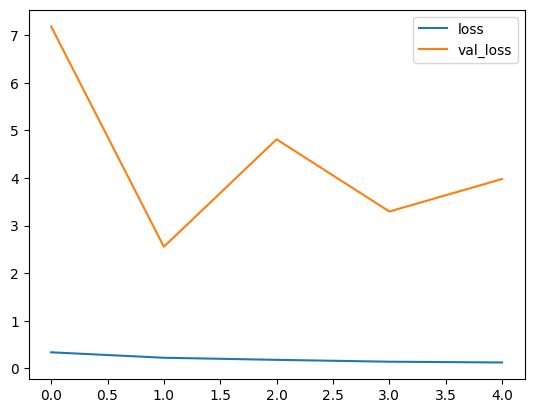

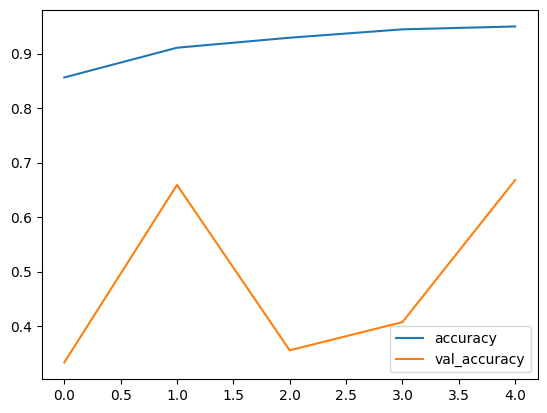

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [21]:
## Evaluate the Model: Evaluate the trained model on a separate test set to understand its performance.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test data generator
test_generator = test_datagen.flow_from_directory(
    'lung_image_sets',  # Replace with the path to your test data
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Important: Do not shuffle the test data
    color_mode='rgb'
)


Found 14985 images belonging to 3 classes.


In [23]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the evaluation results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


235/235 ━━━━━━━━━━━━━━━━━━━━ 92s 390ms/step - accuracy: 0.3107 - loss: 7.8570
Test Loss: 3.7186107635498047
Test Accuracy: 0.6677343845367432


In [24]:
#pip install seaborn

235/235 ━━━━━━━━━━━━━━━━━━━━ 94s 400ms/step


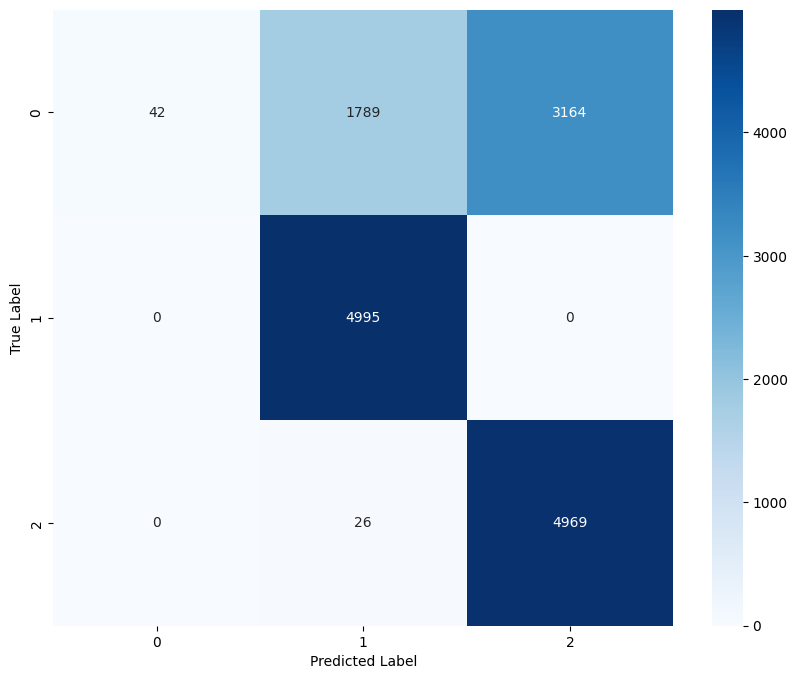

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 93s 395ms/step


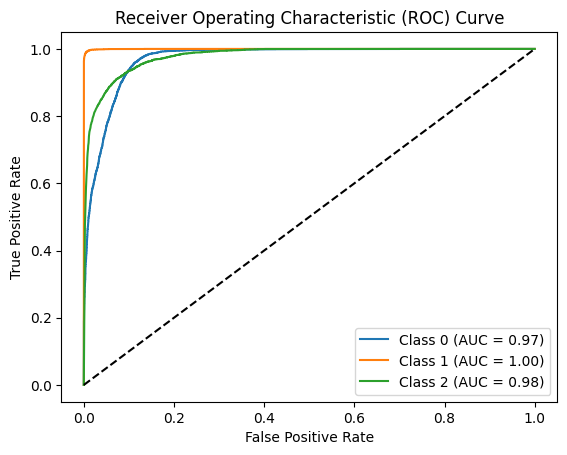

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator)  # Predicted probabilities

# Binarize the true labels (modify this list based on your actual class labels)
classes = [0, 1, 2]  # Example: for a three-class problem
y_true_bin = label_binarize(y_true, classes=classes)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [27]:
### Model Evaluationnnnnnnn

In [28]:
# Save the model in the native Keras format
model.save('weights/weights.keras')

In [29]:
from keras.models import load_model

# Load the model in the native Keras format
model = load_model('weights/weights.keras')

In [30]:
# Compile the model after loading
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
print(model.input_shape)

(None, 256, 256, 3)


In [34]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the pre-trained model
model = load_model('weights/weights.keras')

# Load the image to be classified
image_path = 'For Model Testing/sam1.jpeg'
img = load_img(image_path, target_size=(256, 256))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the input data

# Classify the image
prediction = model.predict(img_array)

# Determine the predicted class
class_names = ['lung_aca', 'lung_n', 'lung_scc']
predicted_class = class_names[np.argmax(prediction[0])]

print(f"The image is classified as: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
The image is classified as: lung_n
